In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from tqdm.auto import tqdm
from copy import deepcopy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [4]:
def combine_df(root_dir, metadata_path):
    dfs = []
    meta_df = pd.read_csv(metadata_path)
    for i in range(meta_df.shape[0]):
        csv_path = meta_df.iloc[i]['Location'] + '.csv'
        measure_df = pd.read_csv(root_dir + csv_path)
        measure_df['Latitude'] = meta_df.iloc[i]['Latitude']
        measure_df['Longitude'] = meta_df.iloc[i]['Longitude']
        dfs.append(measure_df)
    df = pd.concat(dfs, axis=0)
    df.fillna(method='ffill', limit=10, inplace=True)
    df.fillna(df.mean(numeric_only=True), inplace=True)
    return df

root = '/content/drive/MyDrive/Colab Notebooks/AF_pj/dataset/'
pm_df = combine_df(root+'TRAIN/', root+'META/pmmap.csv')
aws_df = combine_df(root+'TRAIN_AWS/', root+'META/awsmap.csv')

print('len pm:', len(pm_df), '/ len aws:', len(aws_df))
display(pm_df.head(2))
display(aws_df.head(2))
pm_label = list(pm_df['측정소'].unique())

len pm: 596088 / len aws: 1051920


,연도,일시,측정소,PM2.5,Latitude,Longitude
0,0,01-01 00:00,아름동,0.044,36.512252,127.246789
1,0,01-01 01:00,아름동,0.048,36.512252,127.246789


,연도,일시,지점,기온(°C),풍향(deg),풍속(m/s),강수량(mm),습도(%),Latitude,Longitude
0,0,01-01 00:00,오월드,0.211690,0.953056,0.033248,0.0,0.791,36.2913,127.3959
1,0,01-01 01:00,오월드,0.205371,0.045556,0.028133,0.0,0.771,36.2913,127.3959


In [7]:
near_pmaws = {'아름동': '세종고운', '신흥동': '세종연서', '노은동': '계룡', '문창동': '오월드', 
              '읍내동': '장동', '정림동': '오월드', '공주': '공주', '논산': '논산', '대천2동': '대천항', 
              '독곶리': '대산', '동문동': '태안', '모종동': '아산', '신방동': '성거', '예산군': '예산', 
              '이원면': '태안', '홍성읍': '홍북', '성성동': '성거'}
df = pm_df.copy()
cols = ['기온(°C)','풍향(deg)','풍속(m/s)','강수량(mm)','습도(%)']
for col in cols:
    df[col] = 0
    for pm_loc, aws_loc in near_pmaws.items():
        df.loc[df['측정소']==pm_loc, col] = aws_df.loc[aws_df['지점']==aws_loc, col]
df['월'] = df['일시'].apply(lambda x: int(x.split('-')[0]))
df['연일시'] = df['연도'].astype('str') + '-' + df['일시']
df.drop(columns=['연도','일시'], inplace=True)
df.iloc[:,2:-1] = df.iloc[:,2:-1]/df.iloc[:,2:-1].max()
# df.set_index('연일시', inplace=True)
df.head(2)

,측정소,PM2.5,Latitude,Longitude,기온(°C),풍향(deg),풍속(m/s),강수량(mm),습도(%),월,연일시
0,아름동,0.044,0.987149,0.998501,0.170886,0.053333,0.041176,0.0,0.773279,0.083333,0-01-01 00:00
1,아름동,0.048,0.987149,0.998501,0.167722,0.099444,0.047059,0.0,0.768219,0.083333,0-01-01 01:00


In [8]:
dfs = {}
for pm_loc in pm_label:
    dfs[pm_loc] = df.loc[df['측정소']==pm_loc, df.columns[1:-1]]
len(dfs['공주']), dfs['공주'].columns

(35064,
 Index(['PM2.5', 'Latitude', 'Longitude', '기온(°C)', '풍향(deg)', '풍속(m/s)',
        '강수량(mm)', '습도(%)', '월'],
       dtype='object'))

In [10]:
en_window_s = 2*24
de_window_s = 3*24
x_data, y_data = [], []
for i in range(dfs['공주'].shape[0] - en_window_s - de_window_s):
    xs, ys = [], []
    for pm_loc, df in dfs.items():
        xs.append(df.iloc[i:i+en_window_s].to_numpy())
        ys.append(df.iloc[i+en_window_s:i+en_window_s+de_window_s, 0])

    x_data.append(xs)
    y = pd.concat(ys, axis=1)
    y_data.append(np.concatenate([np.zeros([1,y.shape[1]]), y], axis=0))
x_data, y_data = np.array(x_data), np.array(y_data)
a,b,c,d = x_data.shape
x_data = x_data.reshape(a,c,b,d)
print(x_data.shape, y_data.shape)

(34944, 48, 17, 9) (34944, 73, 17)


In [27]:
num_valid = 366*24
x_train = x_data[:-num_valid-de_window_s]
y_train = y_data[:-num_valid-de_window_s]
x_valid = x_data[-num_valid:]
y_valid = y_data[-num_valid:]
x_train.shape, y_train.shape, x_valid.shape, y_valid.shape

((26088, 48, 17, 9), (26088, 73, 17), (8784, 48, 17, 9), (8784, 73, 17))

In [28]:
class myDataset(Dataset):
    def __init__(self, en_input, de_input):
        self.en_input, self.de_input = en_input, de_input

    def __len__(self):
        return len(self.en_input)
    
    def __getitem__(self, idx):
        encoder_input = torch.tensor(self.en_input[idx], dtype=torch.float32)
        decoder_input = torch.tensor(self.de_input[idx], dtype=torch.float32)
        return {'encoder_input':encoder_input, 'decoder_input':decoder_input}

trainset = myDataset(x_train, y_train)
validset = myDataset(x_valid, y_valid)
len(trainset), len(validset)

(26088, 8784)

In [29]:
batch_s = 128
trainloader = DataLoader(trainset, batch_size=batch_s, num_workers=1, shuffle=True)
validloader = DataLoader(validset, batch_size=batch_s, num_workers=1, shuffle=False)
len(trainloader), len(validloader)

(204, 69)

In [30]:
batch = next(iter(trainloader))
batch['encoder_input'].shape, batch['decoder_input'].shape

(torch.Size([128, 48, 17, 9]), torch.Size([128, 73, 17]))

In [31]:
batch = next(iter(validloader))
batch['encoder_input'].shape, batch['decoder_input'].shape

(torch.Size([128, 48, 17, 9]), torch.Size([128, 73, 17]))

In [ ]:
batch_s = 16; en_T = 48; en_C = 17; en_cols = 9
# batch_s, encoder timesteps, encoder channels, encoder columns(월, pm2.5, ..., 강수량)
en_hidden_dim = 128 # en_hidden_dim = de_hidden_dim = hidden_dim
n_layers = 3

en_input = torch.randn(batch_s, en_T, en_C, en_cols);  print('encoder input:', en_input.shape)
en_input = en_input.reshape(batch_s*en_T, en_C, en_cols); print('en input reshape:', en_input.shape)
output = nn.Conv1d(17, 17, 3)(en_input);   print('conv1d:', output.shape) # +selu
output = nn.Conv1d(17, 17, 3)(output);    print('conv1d:', output.shape)
output = nn.BatchNorm1d(17)(output);    print('bn:', output.shape) # +selu
output = nn.Conv1d(17,17, 3)(output);    print('conv1d:', output.shape)
output = nn.BatchNorm1d(17)(output);    print('bn:', output.shape) # +selu
output = nn.MaxPool1d(2,stride=2)(output); print('polling:', output.shape)
output = output.reshape(batch_s, en_T, -1); print('output reshape:', output.shape)
hidden = (torch.zeros(n_layers, batch_s, en_hidden_dim),
               torch.zeros(n_layers, batch_s, en_hidden_dim))
print('hidden', hidden[0].shape)
en_output, en_hidden = nn.LSTM(17, en_hidden_dim, n_layers, batch_first=True)(output, hidden)
print('en_output, en_hidden:', en_output.shape, en_hidden[0].shape)

encoder input: torch.Size([16, 48, 17, 9])
en input reshape: torch.Size([768, 17, 9])
conv1d: torch.Size([768, 17, 7])
conv1d: torch.Size([768, 17, 5])
bn: torch.Size([768, 17, 5])
conv1d: torch.Size([768, 17, 3])
bn: torch.Size([768, 17, 3])
polling: torch.Size([768, 17, 1])
output reshape: torch.Size([16, 48, 17])
hidden torch.Size([3, 16, 128])
en_output, en_hidden: torch.Size([16, 48, 128]) torch.Size([3, 16, 128])


In [ ]:
target_n = 17; de_hidden_dim = 128; n_layers = 3
decoder_input = torch.randn(batch_s, 73, target_n)
batch_s, t_len = decoder_input.size(0), decoder_input.size(1)
print(batch_s, t_len)

outputs = torch.zeros(batch_s, t_len-1, target_n)
print('outputs:', outputs.shape)
de_input = decoder_input[:,0]
print('de_input:', de_input.shape) # 64, 17
for t in range(1, t_len):
    if t==1: de_hidden = en_hidden
#     de_output, de_hidden = self.decoder(en_output, de_input, de_hidden)
    de_input = nn.Linear(target_n, en_hidden_dim)(de_input)#.view(batch_s, 1, -1) # 64,1,128
    # cont_v, att_w = self.attention(de_hidden, en_output)
    print('de_input',de_input.shape, de_input.unsqueeze(1).shape, de_input.view(batch_s,1,-1).shape)
    A = nn.Linear(128,128)(de_input.view(batch_s,1,-1))
    B = nn.Linear(128,128)(en_output)
    AB = A+B
    print('A,B,AB:', A.shape, B.shape, AB.shape)
    score = nn.Linear(128,1)(torch.tanh(AB))
    print('score:', score.shape)
    att_w = torch.softmax(score, axis=1)
    print('att_w:', att_w.shape)
    cont_v = att_w*en_output
    print('cont_v:', cont_v.shape)
    cont_v = torch.sum(cont_v, dim=1)
    print('total cont_v:', cont_v.shape)
    print('sum cont_v:', torch.sum(cont_v, dim=0).unsqueeze(0).shape)
    de_input = torch.cat([cont_v, de_input], dim=1)
    print('concat:', de_input.shape) # 64,256
    de_input = de_input.unsqueeze(0)
    print('de_input:', de_input.shape) # 1,64,256
    de_output, de_hidden = nn.LSTM(en_hidden_dim*2, de_hidden_dim, n_layers)(de_input, de_hidden)
    print('de_output, h', de_output.shape, de_hidden[0].shape) # 1,64,128 / 3,64,128
    print('de_output.sum(0)', de_output.sum(0).shape) # 64,128
    pred = nn.Linear(de_hidden_dim, target_n)(de_output.sum(0))
    print('pred:', pred.shape)
    outputs[:,t-1] = pred
    # if training:
    #     de_input = decoder_input[:,t]
    # else:
    #     de_input = output
    if t==1: break

16 73
outputs: torch.Size([16, 72, 17])
de_input: torch.Size([16, 17])
de_input torch.Size([16, 128]) torch.Size([16, 1, 128]) torch.Size([16, 1, 128])
A,B,AB: torch.Size([16, 1, 128]) torch.Size([16, 48, 128]) torch.Size([16, 48, 128])
score: torch.Size([16, 48, 1])
att_w: torch.Size([16, 48, 1])
cont_v: torch.Size([16, 48, 128])
total cont_v: torch.Size([16, 128])
sum cont_v: torch.Size([1, 128])
concat: torch.Size([16, 256])
de_input: torch.Size([1, 16, 256])
de_output, h torch.Size([1, 16, 128]) torch.Size([3, 16, 128])
de_output.sum(0) torch.Size([16, 128])
pred: torch.Size([16, 17])


In [16]:
class Encoder(nn.Module):
    def __init__(self, input_dim, en_hidden_dim, n_layers):
        super().__init__()
        self.n_layers = n_layers
        self.en_hidden_dim = en_hidden_dim
        self.cnn = nn.Sequential(nn.Conv1d(input_dim, input_dim, 3), # 768,17,7
                                 nn.SELU(),
                                 nn.Conv1d(input_dim, input_dim, 3), # 768,17,5
                                 nn.BatchNorm1d(input_dim), nn.SELU(),
                                 nn.Conv1d(input_dim, input_dim, 3), # 768,17,3
                                 nn.BatchNorm1d(input_dim), nn.SELU(),
                                 nn.AvgPool1d(2, stride=2)) #768,17,1
        self.lstm = nn.LSTM(input_dim, en_hidden_dim, n_layers, batch_first=True)
        
    def forward(self, en_input): # en_input: batch_s, times, channels, cols
        N,T,Ch,Co = en_input.shape # 16, 48, 17, 9
        en_input = en_input.reshape(N*T, Ch, Co) # 768, 17, 9
        cnn_output = self.cnn(en_input) # 768, 17, 1
        cnn_output = cnn_output.reshape(N,T,-1) # 16, 48, 17
        en_hidden = self.init_hidden(N)
        en_output, en_hidden = self.lstm(cnn_output, en_hidden) # 16,48,128 / 3,16,128
        return en_output, en_hidden
    
    def init_hidden(self, batch_s):
        return (torch.zeros(self.n_layers, batch_s, self.en_hidden_dim, device=device),
               torch.zeros(self.n_layers, batch_s, self.en_hidden_dim, device=device))
        
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.fc_encoder = nn.Linear(hidden_dim, hidden_dim)
        self.fc_deinput = nn.Linear(hidden_dim, hidden_dim)
        self.scoring = nn.Linear(hidden_dim, 1)
        
    def forward(self, en_output, de_input):
        fc_en = self.fc_encoder(en_output) # 16,48,128
        fc_de = self.fc_deinput(de_input.unsqueeze(1)) # 16,1,128
        score = self.scoring(torch.tanh(fc_en+fc_de)) # 16,48,1
        att_w = torch.softmax(score, axis=1) # 16,48,1
        cont_v = att_w * en_output # 16,48,128
        cont_v = torch.sum(cont_v, dim=1) # 16,128
        return cont_v, att_w

class Decoder(nn.Module):
    def __init__(self, de_input_s, en_hidden_dim, de_hidden_dim, output_dim,
                 n_layers, attention):
        super().__init__()
        self.n_layers, self.de_hidden_dim = n_layers, de_hidden_dim
        self.attention = attention
        self.output_dim = output_dim
        
        self.layer = nn.Linear(de_input_s, en_hidden_dim)
        self.lstm = nn.LSTM(en_hidden_dim*2, de_hidden_dim, n_layers)
        self.fc = nn.Linear(de_hidden_dim, output_dim)
        
    def forward(self, en_output, de_input, de_hidden):
        N,_ = de_input.shape # 16,17
        de_input = self.layer(de_input) # 16,128
        cont_v, att_w = self.attention(en_output, de_input)
        de_input = torch.cat([cont_v, de_input], dim=1) # 64,256
        de_input = de_input.unsqueeze(0) # 1,64,256
        de_hidden = self.init_hidden(N)
        de_output, de_hidden = self.lstm(de_input, de_hidden) # 1,16,128 / 3,16,128
        de_output = de_output.sum(0) # 16,128
        de_output = self.fc(de_output) # 16,17
        return de_output, de_hidden

    def init_hidden(self, batch_s):
        return (torch.zeros(self.n_layers, batch_s, self.de_hidden_dim, device=device),
               torch.zeros(self.n_layers, batch_s, self.de_hidden_dim, device=device))
        
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, attention):
        super().__init__()
        self.encoder, self.decoder = encoder, decoder
        self.attention = attention
        
    def forward(self, en_input, decoder_input, training=True):
        N,T,target_n = decoder_input.shape # 16,73,17
        outputs = torch.zeros(N, T-1, target_n).to(device) # 16,72,17
        en_output, en_hidden = self.encoder(en_input)
        de_input = decoder_input[:,0] # 16,17
        for t in range(0, T-1):
            if t==0: de_hidden = en_hidden
            de_output, de_hidden = self.decoder(en_output, de_input, de_hidden)
            outputs[:,t] = de_output # 16,17
            if training:
                de_input = decoder_input[:,t+1]
            else:
                de_input = de_output
        return outputs

In [17]:
target_n = 17 # 맞춰야하는 관측소 pm2.5 수
n_layers = 3 # lstm 레이어 층
hidden_dim = 128 # lstm 히든차원

encoder = Encoder(input_dim=target_n, en_hidden_dim=hidden_dim, n_layers=n_layers)
attention = Attention(hidden_dim=hidden_dim)
decoder = Decoder(de_input_s=target_n, en_hidden_dim=hidden_dim, de_hidden_dim=hidden_dim,
                  output_dim=target_n, n_layers=n_layers, attention=attention)
model = Seq2Seq(encoder, decoder, attention)
model.to(device)

Seq2Seq(
  (encoder): Encoder(
    (cnn): Sequential(
      (0): Conv1d(17, 17, kernel_size=(3,), stride=(1,))
      (1): SELU()
      (2): Conv1d(17, 17, kernel_size=(3,), stride=(1,))
      (3): BatchNorm1d(17, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): SELU()
      (5): Conv1d(17, 17, kernel_size=(3,), stride=(1,))
      (6): BatchNorm1d(17, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (7): SELU()
      (8): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
    )
    (lstm): LSTM(17, 128, num_layers=3, batch_first=True)
  )
  (decoder): Decoder(
    (attention): Attention(
      (fc_encoder): Linear(in_features=128, out_features=128, bias=True)
      (fc_deinput): Linear(in_features=128, out_features=128, bias=True)
      (scoring): Linear(in_features=128, out_features=1, bias=True)
    )
    (layer): Linear(in_features=17, out_features=128, bias=True)
    (lstm): LSTM(256, 128, num_layers=3)
    (fc): Linear(in_features=

In [37]:
class myTrain():
    def __init__(self, trainloader, validloader, model, pm_label, pm_max=70, de_window_s=3*24, target_n=17):
        self.trainloader, self.validloader = trainloader, validloader
        self.model = model
        self.save_best_pth, self.save_last_pth = 'best_checkpoint.pth', 'last_checkpoint.pth'
        self.pm_label, self.pm_max = pm_label, pm_max

    def train_loop(self, epochs, loss_fn, optimizer, scheduler, patience):
        self.train_loss_li, self.valid_loss_li = [], []
        trigger = 0
        for epoch in range(1,epochs+1):
            self.model.train()
            train_loss = []
            train_tqdm = tqdm(self.trainloader)
            for batch in train_tqdm:
                encoder_input = batch['encoder_input'].to(device)
                decoder_input = batch['decoder_input'].to(device)
                output = self.model(encoder_input, decoder_input, training=True)
                loss = loss_fn(output, decoder_input[:,1:])
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                train_loss.append(loss.item())

                train_tqdm.set_postfix({'Epoch':epoch,
                                        'Loss':'{:.3f}'.format(train_loss[-1]*self.pm_max),
                                        'meanLoss':'{:.3f}'.format(np.mean(train_loss)*self.pm_max)})
            self.train_loss_li.append(np.mean(train_loss)*self.pm_max)
            self.valid_loss_li.append(self.validate(loss_fn)*self.pm_max)
            
            if np.min(self.valid_loss_li)==self.valid_loss_li[-1]:
                best_state = deepcopy(self.model.state_dict())
                torch.save(best_state, self.save_best_pth)
                self.best_epoch = epoch
                tigger = 0
            else:
                trigger += 1
                if trigger>patience:
                    print('\nEarly Stopping!! epoch/epochs: {}/{}'.format(epoch, epochs))
                    break
            scheduler.step(self.valid_loss_li[-1])
        last_state = deepcopy(self.model.state_dict())
        torch.save(last_state, self.save_last_pth)

    def validate(self, loss_fn):
        self.valid_output = []
        self.model.eval()
        valid_loss = []
        # valid_tqdm = tqdm(self.validloader)
        valid_tqdm = self.validloader
        with torch.no_grad():
            for batch in valid_tqdm:
                encoder_input = batch['encoder_input'].to(device)
                decoder_input = batch['decoder_input'].to(device)
                output = self.model(encoder_input, decoder_input, training=False)
                loss = loss_fn(output, decoder_input[:,1:]).item()
                valid_loss.append(loss)
                # valid_tqdm.set_postfix({'ValidLoss':'{:.3f}'.format(valid_loss[-1]),
                #                         'meanValidLoss':'{:.3f}'.format(np.mean(valid_loss))})
                self.valid_output += output
        return np.mean(valid_loss)

    def loss_plot(self):
        fig, ax = plt.subplots(figsize=(5,3))
        ax.plot(self.train_loss_li, label='train MAE')
        ax.plot(self.valid_loss_li, label='valid MAE')
        ax.vlines(self.best_epoch-1, min(self.train_loss_li), max(self.valid_loss_li), colors='lightgray', linestyle='--')
        plt.title('L1 Loss: MAE'); plt.legend()
        plt.show()

    def evaluate(self, model, testloader, submit):
        model.eval()
        batch_s = next(iter(testloader))['encoder_input'].shape[0]
        preds = torch.zeros(batch_s*de_window_s, len(testloader), target_n)
        test_tqdm = tqdm(enumerate(testloader))
        with torch.no_grad():
            for i,batch in test_tqdm:
                encoder_input = batch['encoder_input'].to(device)
                decoder_input = torch.zeros([1,de_window_s+1, target_n], dtype=torch.float32).to(device)
                output = model(encoder_input, decoder_input, training=False)
                preds[:,i] = output.view(-1, target_n)
        preds = preds.view(-1, target_n).cpu()
        for i,pm_loc in enumerate(self.pm_label):
            submit.loc[submit['측정소']==pm_loc, 'PM2.5'] = preds[:,i].numpy().tolist()
        return submit 

    def predict(self, model, testloader, submit, best_opt=True, last_opt=True):
        if best_opt:
            best_dict = torch.load(self.save_best_pth)
            best_model = model
            best_model.load_state_dict(best_dict)
            self.best_submit = self.evaluate(best_model, testloader, submit)
        if last_opt:
            last_dict = torch.load(self.save_last_pth)
            last_model = model
            last_model.load_state_dict(last_dict)
            self.last_submit = self.evaluate(last_model, testloader, submit)

  0%|          | 0/204 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch 00006: reducing learning rate of group 0 to 1.0000e-05.


  0%|          | 0/204 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch 00009: reducing learning rate of group 0 to 1.0000e-06.


  0%|          | 0/204 [00:00<?, ?it/s]


Early Stopping!! epoch/epochs: 10/30


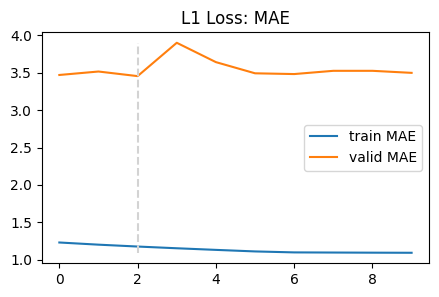

In [38]:
batch_s = 128
trainloader = DataLoader(trainset, batch_size=batch_s, num_workers=1, shuffle=True)
validloader = DataLoader(validset, batch_size=batch_s, num_workers=1, shuffle=False)
model = Seq2Seq(encoder, decoder, attention)
model = model.to(device)

lr = 0.0001; epochs = 30; patience=7
loss_fn = nn.L1Loss() # MAE
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)
myRNN = myTrain(trainloader, validloader, model, pm_label)
myRNN.train_loop(epochs, loss_fn, optimizer, scheduler, patience)
myRNN.loss_plot()
# submit = pd.read_csv(root+'answer_sample.csv')
# myRNN.predict(model, testloader, submit, best_opt=True, last_opt=True)

  0%|          | 0/408 [00:00<?, ?it/s]

  0%|          | 0/408 [00:00<?, ?it/s]

  0%|          | 0/408 [00:00<?, ?it/s]

  0%|          | 0/408 [00:00<?, ?it/s]

  0%|          | 0/408 [00:00<?, ?it/s]

  0%|          | 0/408 [00:00<?, ?it/s]

  0%|          | 0/408 [00:00<?, ?it/s]

Epoch 00007: reducing learning rate of group 0 to 1.0000e-05.


  0%|          | 0/408 [00:00<?, ?it/s]

  0%|          | 0/408 [00:00<?, ?it/s]

  0%|          | 0/408 [00:00<?, ?it/s]

Epoch 00010: reducing learning rate of group 0 to 1.0000e-06.


  0%|          | 0/408 [00:00<?, ?it/s]


Early Stopping!! epoch/epochs: 11/30


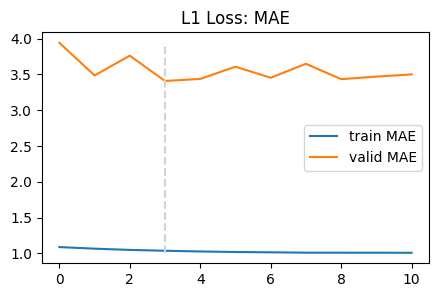

In [39]:
batch_s = 64
trainloader = DataLoader(trainset, batch_size=batch_s, num_workers=1, shuffle=True)
validloader = DataLoader(validset, batch_size=batch_s, num_workers=1, shuffle=False)
model = Seq2Seq(encoder, decoder, attention)
model = model.to(device)

lr = 0.0001; epochs = 30; patience=7
loss_fn = nn.L1Loss() # MAE
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)
myRNN = myTrain(trainloader, validloader, model, pm_label)
myRNN.train_loop(epochs, loss_fn, optimizer, scheduler, patience)
myRNN.loss_plot()
# submit = pd.read_csv(root+'answer_sample.csv')
# myRNN.predict(model, testloader, submit, best_opt=True, last_opt=True)

  0%|          | 0/816 [00:00<?, ?it/s]

  0%|          | 0/816 [00:00<?, ?it/s]

  0%|          | 0/816 [00:00<?, ?it/s]

  0%|          | 0/816 [00:00<?, ?it/s]

  0%|          | 0/816 [00:00<?, ?it/s]

  0%|          | 0/816 [00:00<?, ?it/s]

Epoch 00006: reducing learning rate of group 0 to 1.0000e-05.


  0%|          | 0/816 [00:00<?, ?it/s]

  0%|          | 0/816 [00:00<?, ?it/s]

  0%|          | 0/816 [00:00<?, ?it/s]

Epoch 00009: reducing learning rate of group 0 to 1.0000e-06.


  0%|          | 0/816 [00:00<?, ?it/s]

  0%|          | 0/816 [00:00<?, ?it/s]


Early Stopping!! epoch/epochs: 11/30


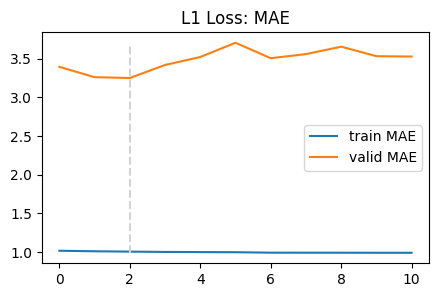

In [40]:
batch_s = 32
trainloader = DataLoader(trainset, batch_size=batch_s, num_workers=1, shuffle=True)
validloader = DataLoader(validset, batch_size=batch_s, num_workers=1, shuffle=False)
model = Seq2Seq(encoder, decoder, attention)
model = model.to(device)

lr = 0.0001; epochs = 30; patience=7
loss_fn = nn.L1Loss() # MAE
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)
myRNN = myTrain(trainloader, validloader, model, pm_label)
myRNN.train_loop(epochs, loss_fn, optimizer, scheduler, patience)
myRNN.loss_plot()
# submit = pd.read_csv(root+'answer_sample.csv')
# myRNN.predict(model, testloader, submit, best_opt=True, last_opt=True)

In [41]:
batch_s = 16
trainloader = DataLoader(trainset, batch_size=batch_s, num_workers=1, shuffle=True)
validloader = DataLoader(validset, batch_size=batch_s, num_workers=1, shuffle=False)
model = Seq2Seq(encoder, decoder, attention)
model = model.to(device)

lr = 0.0001; epochs = 30; patience=7
loss_fn = nn.L1Loss() # MAE
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)
myRNN = myTrain(trainloader, validloader, model, pm_label)
myRNN.train_loop(epochs, loss_fn, optimizer, scheduler, patience)
myRNN.loss_plot()
# submit = pd.read_csv(root+'answer_sample.csv')
# myRNN.predict(model, testloader, submit, best_opt=True, last_opt=True)

  0%|          | 0/1631 [00:00<?, ?it/s]

  0%|          | 0/1631 [00:00<?, ?it/s]

  0%|          | 0/1631 [00:00<?, ?it/s]

  0%|          | 0/1631 [00:00<?, ?it/s]

  0%|          | 0/1631 [00:00<?, ?it/s]

  0%|          | 0/1631 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4e7b85df30>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1443, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.10/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.10/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 931, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.10/selectors.py", line 416, in select
    fd_event_list = self._selector.poll(timeout)
KeyboardInterrupt: 


RuntimeError: ignored

In [ ]:
# pm_label: 순서로 타깃칼럼에 들어있을 걸..?
# output: batch_s, 72, 17
# test df 넣을 때는 모든 시간 슬라이싱이 아니라 5일단위로 슬라이싱(그리고 셔플없음)
# 그러면 test 출력은 3일(3,4,5), 3일(8,9,10), ... 로 끊겨서 나올텐데
# 아니다 test 점수는 거기서 알아서 해줄건데 뭐...
# 그러면 train 출력 점수가 문제인데 하나의 배치마다 점수를 계산해야 된다면 그냥 비교해서 하면 되려나


In [ ]:
# from ignite.metrics import *